In [92]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
import os

# Create a datfaframe to hold facets sensor location data
sensor_location_data = {'Sensor ID': [], 'Sensor Description': [], 'Status': [], 'Location Type': [], 'Longitude': [], 'Latitude': []}
sensor_location_df = pd.DataFrame(sensor_location_data)

sensor_location_df

,Sensor ID,Sensor Description,Status,Location Type,Longitude,Latitude


In [93]:
# Set the API base URL
url = 'https://data.melbourne.vic.gov.au/api/'

# Define the endpoint and query parameters
endpoint = '/records/1.0/search/'
params = {
    'dataset': 'pedestrian-counting-system-sensor-locations',
    'q': '',
    'facet': 'location_id'
}

# Send the API request to get the list of distinct Sensor IDs
response = requests.get(url + endpoint, params=params)
data = response.json()
sensor_ids = [f['name'] for f in data['facet_groups'][0]['facets']]

# Create an empty list to store the results
results = []

# Loop through the Sensor IDs to retrieve the data for each sensor
for sensor_id in sensor_ids:
    params['q'] = f'location_id:"{sensor_id}"'
    response = requests.get(url + endpoint, params=params)
    data = response.json()
    records = data['records']

    for record in records:
        sensor_location_data = {
            'Sensor ID': record['fields']['location_id'],
            'Sensor Description': record['fields']['sensor_description'],
            'Status': record['fields']['status'],
            'Location Type': record['fields']['location_type'],
            'Longitude': record['fields']['longitude'],
            'Latitude': record['fields']['latitude']
        }
        results.append(sensor_location_data)

# Convert the results to a DataFrame
sensor_location_df = pd.DataFrame(results)

# Print summary
print("Data Retrieval Complete")
print(f"Number of Records: {len(sensor_location_df)}")

filename = '../Datasets/sensor_locations.csv'
sensor_location_df.to_csv(filename, index=False)

# Display the dataframe
sensor_location_df


Data Retrieval Complete
Number of Records: 100


,Sensor ID,Sensor Description,Status,Location Type,Longitude,Latitude
0,1,Bourke Street Mall (North),A,Outdoor,144.965153,-37.813494
1,2,Bourke Street Mall (South),A,Outdoor,144.965167,-37.813807
2,3,Melbourne Central,A,Outdoor,144.964295,-37.811015
3,4,Town Hall (West),A,Outdoor,144.966088,-37.814880
4,5,Princes Bridge,A,Outdoor,144.967877,-37.818742
...,...,...,...,...,...,...
95,110,Birrarung Marr East Entry,A,Outdoor Blix,144.975902,-37.821029
96,111,Harbour Esplanade,A,Outdoor Blix,144.944366,-37.814426
97,112,Argyle Sq Park,A,Outdoor Blix,144.965642,-37.802553
98,113,Micro-labs Blix,A,Indoor Blix,144.966893,-37.813345


In [94]:
import hvplot.pandas
import geoviews as gv
import geoviews.feature as gf
from geoviews import opts


sensors_map = sensor_location_df.hvplot.points(
    "Longitude",
    "Latitude",
    geo = True,
    tiles = "CartoLight",
    frame_width = 800,
    frame_height = 600,
    color = "Status",
    alpha = 0.5,
    hover_cols=["Sensor ID", "Sensor Description"]
)
print(f"Number of sensors in the list: {len(sensor_location_df)}")
sensors_map

Number of sensors in the list: 100


:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (Status,Sensor ID,Sensor Description)

In [95]:
# Pedestrian sensor data file
pedestrian_sensor_counts_path = "../Datasets/Pedestrian_Counting_System_Monthly_counts_per_hour_may_2009_to_14_dec_2022.csv"

# Read the pedestrian sensor data file
pedestrian_sensor_counts = pd.read_csv(pedestrian_sensor_counts_path)


pedestrian_sensor_counts_df = pd.DataFrame(pedestrian_sensor_counts)
pedestrian_sensor_counts_df

,ID,Date_Time,Year,Month,Mdate,Day,Time,Sensor_ID,Sensor_Name,Hourly_Counts
0,2887628,"November 01, 2019 05:00:00 PM",2019,November,1,Friday,17,34,Flinders St-Spark La,300
1,2887629,"November 01, 2019 05:00:00 PM",2019,November,1,Friday,17,39,Alfred Place,604
2,2887630,"November 01, 2019 05:00:00 PM",2019,November,1,Friday,17,37,Lygon St (East),216
3,2887631,"November 01, 2019 05:00:00 PM",2019,November,1,Friday,17,40,Lonsdale St-Spring St (West),627
4,2887632,"November 01, 2019 05:00:00 PM",2019,November,1,Friday,17,36,Queen St (West),774
...,...,...,...,...,...,...,...,...,...,...
4562225,4567697,"October 31, 2022 07:00:00 PM",2022,October,31,Monday,19,87,Errol St (West),185
4562226,4567698,"October 31, 2022 08:00:00 PM",2022,October,31,Monday,20,87,Errol St (West),108
4562227,4567699,"October 31, 2022 09:00:00 PM",2022,October,31,Monday,21,87,Errol St (West),58
4562228,4567700,"October 31, 2022 10:00:00 PM",2022,October,31,Monday,22,87,Errol St (West),18


In [96]:
# group the rows by Sensor_ID, Year, Month, and Mdate columns
grouped_df = pedestrian_sensor_counts_df.groupby(['Sensor_ID', 'Year', 'Month', 'Mdate'])

# aggregate the data using the sum function
summed_df = grouped_df.sum(numeric_only=True)

# reset the index to make the columns Sensor_ID, Year, Month, and Mdate regular columns
summed_df = summed_df.reset_index()

# filter the rows based on the given conditions
filtered_df = summed_df[(summed_df['Mdate'] == 1) & (summed_df['Year'].isin([2018, 2020, 2022]))]

# reset the index
filtered_df = filtered_df.reset_index(drop=True)

filtered_df = filtered_df.drop(['Time', 'ID'], axis=1)

filtered_df = filtered_df.rename(columns={'Hourly_Counts': 'Daily Count'})
filtered_df = filtered_df.rename(columns={'Sensor_ID': 'Sensor ID'})

num_unique_sensors = filtered_df['Sensor ID'].nunique()
print(f"Number of unique sensors: {num_unique_sensors}")

filtered_df

Number of unique sensors: 77


,Sensor ID,Year,Month,Mdate,Daily Count
0,1,2018,April,1,32566
1,1,2018,August,1,31572
2,1,2018,December,1,43833
3,1,2018,February,1,32029
4,1,2018,January,1,28085
...,...,...,...,...,...
1952,86,2022,September,1,1517
1953,87,2022,August,1,2327
1954,87,2022,July,1,2918
1955,87,2022,October,1,3314


In [97]:
mean_df = filtered_df.groupby(['Sensor ID', 'Year']).agg({'Daily Count': 'mean'}).reset_index()

mean_df

,Sensor ID,Year,Daily Count
0,1,2018,33300.000000
1,1,2020,12806.750000
2,1,2022,16719.300000
3,2,2018,23232.166667
4,2,2020,8165.166667
...,...,...,...
188,79,2022,10673.200000
189,84,2022,20860.300000
190,85,2022,1769.500000
191,86,2022,1275.000000


In [98]:
merged_df = pd.merge(mean_df, sensor_location_df, on='Sensor ID')

# filter the DataFrame for 2018 and 2022
df_2018 = merged_df[merged_df['Year'] == 2018]
df_2020 = merged_df[merged_df['Year'] == 2020]
df_2022 = merged_df[merged_df['Year'] == 2022]

# group the DataFrames by Sensor_ID
grouped_df_2018 = df_2018.groupby('Sensor ID')
grouped_df_2020 = df_2020.groupby('Sensor ID')
grouped_df_2022 = df_2022.groupby('Sensor ID')

# compute the daily count for each Sensor_ID and year
count_2018 = grouped_df_2018['Daily Count'].sum().reset_index()
count_2020 = grouped_df_2020['Daily Count'].sum().reset_index()
count_2022 = grouped_df_2022['Daily Count'].sum().reset_index()

count_2018 = count_2018.rename(columns={'Daily Count': 'Daily Count_2018'})

diff_df = pd.merge(pd.merge(count_2022, count_2020, on='Sensor ID', suffixes=('_2022', '_2020')), count_2018, on='Sensor ID')

diff_df

,Sensor ID,Daily Count_2022,Daily Count_2020,Daily Count_2018
0,1,16719.300000,12806.750000,33300.000000
1,2,12016.300000,8165.166667,23232.166667
2,3,21593.300000,12434.750000,30793.000000
3,4,26680.000000,13666.416667,35049.166667
4,5,19906.200000,12701.000000,33777.750000
5,6,18711.300000,10780.166667,34649.250000
6,7,2628.000000,3094.916667,8181.500000
7,8,3588.000000,2902.000000,4831.250000
8,9,6153.800000,2025.666667,16612.250000
9,10,1520.900000,950.583333,4335.583333


In [99]:
# compute the daily count difference for each Sensor_ID
diff_df['Daily Count_Diff'] = diff_df['Daily Count_2022'] - diff_df['Daily Count_2018']

# create new column with percentage change
diff_df['Daily_Count_Diff_Pct'] = 100 * (diff_df['Daily Count_Diff'] / diff_df['Daily Count_2018'])

# round the percentage change to two decimal places
diff_df['Daily_Count_Diff_Pct'] = diff_df['Daily_Count_Diff_Pct'].round(2)

# merge diff_df with sensor_location_df
diff_2022_2018_df = pd.merge(diff_df, sensor_location_df, on='Sensor ID')

# select and reorder columns
diff_2022_2018_df = diff_2022_2018_df[['Sensor ID', 'Sensor Description', 'Latitude', 'Longitude', 
                                 'Daily Count_2022', 'Daily Count_2018', 'Daily Count_Diff', 'Daily_Count_Diff_Pct']]

diff_2022_2018_df


,Sensor ID,Sensor Description,Latitude,Longitude,Daily Count_2022,Daily Count_2018,Daily Count_Diff,Daily_Count_Diff_Pct
0,1,Bourke Street Mall (North),-37.813494,144.965153,16719.300000,33300.000000,-16580.700000,-49.79
1,2,Bourke Street Mall (South),-37.813807,144.965167,12016.300000,23232.166667,-11215.866667,-48.28
2,3,Melbourne Central,-37.811015,144.964295,21593.300000,30793.000000,-9199.700000,-29.88
3,4,Town Hall (West),-37.814880,144.966088,26680.000000,35049.166667,-8369.166667,-23.88
4,5,Princes Bridge,-37.818742,144.967877,19906.200000,33777.750000,-13871.550000,-41.07
5,6,Flinders Street Station Underpass,-37.819117,144.965583,18711.300000,34649.250000,-15937.950000,-46.00
6,7,Birrarung Marr,-37.818629,144.971694,2628.000000,8181.500000,-5553.500000,-67.88
7,8,Webb Bridge,-37.822935,144.947175,3588.000000,4831.250000,-1243.250000,-25.73
8,9,Southern Cross Station,-37.819830,144.951026,6153.800000,16612.250000,-10458.450000,-62.96
9,10,Victoria Point,-37.818765,144.947105,1520.900000,4335.583333,-2814.683333,-64.92


In [100]:
# compute the daily count difference for each Sensor_ID
diff_df['Daily Count_Diff'] = diff_df['Daily Count_2022'] - diff_df['Daily Count_2020']

# create new column with percentage change
diff_df['Daily_Count_Diff_Pct'] = 100 * (diff_df['Daily Count_Diff'] / diff_df['Daily Count_2020'])

# round the percentage change to two decimal places
diff_df['Daily_Count_Diff_Pct'] = diff_df['Daily_Count_Diff_Pct'].round(2)

# merge diff_df with sensor_location_df
diff_2022_2020_df = pd.merge(diff_df, sensor_location_df, on='Sensor ID')

# select and reorder columns
diff_2022_2020_df = diff_2022_2020_df[['Sensor ID', 'Sensor Description', 'Latitude', 'Longitude', 
                                 'Daily Count_2022', 'Daily Count_2020', 'Daily Count_Diff', 'Daily_Count_Diff_Pct']]

diff_2022_2020_df


,Sensor ID,Sensor Description,Latitude,Longitude,Daily Count_2022,Daily Count_2020,Daily Count_Diff,Daily_Count_Diff_Pct
0,1,Bourke Street Mall (North),-37.813494,144.965153,16719.300000,12806.750000,3912.550000,30.55
1,2,Bourke Street Mall (South),-37.813807,144.965167,12016.300000,8165.166667,3851.133333,47.17
2,3,Melbourne Central,-37.811015,144.964295,21593.300000,12434.750000,9158.550000,73.65
3,4,Town Hall (West),-37.814880,144.966088,26680.000000,13666.416667,13013.583333,95.22
4,5,Princes Bridge,-37.818742,144.967877,19906.200000,12701.000000,7205.200000,56.73
5,6,Flinders Street Station Underpass,-37.819117,144.965583,18711.300000,10780.166667,7931.133333,73.57
6,7,Birrarung Marr,-37.818629,144.971694,2628.000000,3094.916667,-466.916667,-15.09
7,8,Webb Bridge,-37.822935,144.947175,3588.000000,2902.000000,686.000000,23.64
8,9,Southern Cross Station,-37.819830,144.951026,6153.800000,2025.666667,4128.133333,203.79
9,10,Victoria Point,-37.818765,144.947105,1520.900000,950.583333,570.316667,60.00


In [101]:
# Hypothesis: The volume of pedestrian traffic in Melbourne's CBD has decreased between 2018-2022.

# Null hypothesis: There has been no significant change in the volume of pedestrian traffic in Melbourne's CBD over the time frame.

In [102]:
# Define a scaling function for the size of the points based on the magnitude of the negative values
def scale_size(x):
    if x < 0:
        return np.abs(x) * 10
    else:
        return x * 10

# Define a function to map the color based on the sign of the value
def color_map(x):
    if x < 0:
        return 'red'
    else:
        return 'blue'

# Create the plot with scaled size and color based on the Daily_Count_Diff_Pct values
filtered_sensors_2022_2020_map = diff_2022_2020_df.hvplot.points(
    "Longitude",
    "Latitude",
    geo=True,
    tiles="CartoLight",
    frame_width=800,
    frame_height=600,
    color=diff_2022_2020_df['Daily_Count_Diff_Pct'].apply(color_map),
    size=diff_2022_2020_df['Daily_Count_Diff_Pct'].apply(scale_size),
    alpha=0.5,
    hover_cols=["Sensor ID", "Sensor Description", "Daily_Count_Diff_Pct"],
    colorbar=True,
)

print(f"Number of sensors in the list: {len(diff_2022_2020_df)}")
filtered_sensors_2022_2020_map


Number of sensors in the list: 50


:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (_color,_size,Sensor ID,Sensor Description,Daily_Count_Diff_Pct)

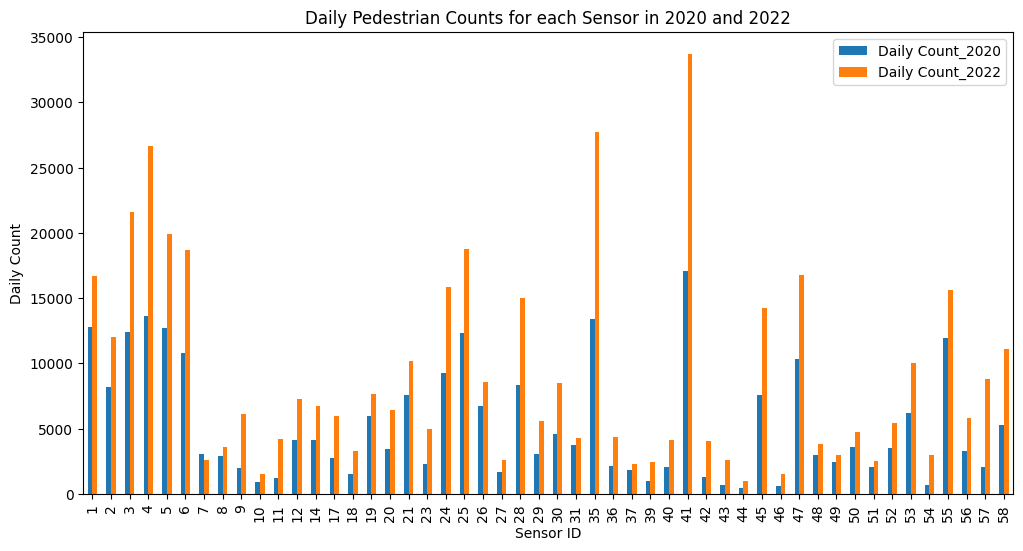

In [103]:
import matplotlib.pyplot as plt

# Group the data by sensor ID and select the daily count columns
sensor_counts = diff_2022_2020_df.groupby('Sensor ID')[['Daily Count_2020', 'Daily Count_2022']].sum()

# Plot a bar chart for each sensor
sensor_counts.plot(kind='bar', figsize=(12,6))

# Add title and labels
plt.title("Daily Pedestrian Counts for each Sensor in 2020 and 2022")
plt.xlabel("Sensor ID")
plt.ylabel("Daily Count")
plt.show()


In [104]:
import scipy.stats as stats

# Extract the daily counts for each sensor and time period
counts_2020 = diff_2022_2020_df['Daily Count_2020'].tolist()
counts_2022 = diff_2022_2020_df['Daily Count_2022'].tolist()

# Perform the ANOVA
f_stat, p_val = stats.f_oneway(counts_2020, counts_2022)

# Print the results
print("F-statistic:", f_stat)
print("p-value:", p_val)

F-statistic: 9.287597080355953
p-value: 0.002965375104379417


In [105]:
# Define a scaling function for the size of the points based on the magnitude of the negative values
def scale_size(x):
    if x < 0:
        return np.abs(x) * 10
    else:
        return x * 10

# Define a function to map the color based on the sign of the value
def color_map(x):
    if x < 0:
        return 'red'
    else:
        return 'blue'

# Create the plot with scaled size and color based on the Daily_Count_Diff_Pct values
filtered_sensors_2022_2018_map = diff_2022_2018_df.hvplot.points(
    "Longitude",
    "Latitude",
    geo=True,
    tiles="CartoLight",
    frame_width=800,
    frame_height=600,
    color=diff_2022_2018_df['Daily_Count_Diff_Pct'].apply(color_map),
    size=diff_2022_2018_df['Daily_Count_Diff_Pct'].apply(scale_size),
    alpha=0.5,
    hover_cols=["Sensor ID", "Sensor Description", "Daily_Count_Diff_Pct"],
    colorbar=True,
)

print(f"Number of sensors in the list: {len(diff_2022_2020_df)}")
filtered_sensors_2022_2018_map

Number of sensors in the list: 50


:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (_color,_size,Sensor ID,Sensor Description,Daily_Count_Diff_Pct)

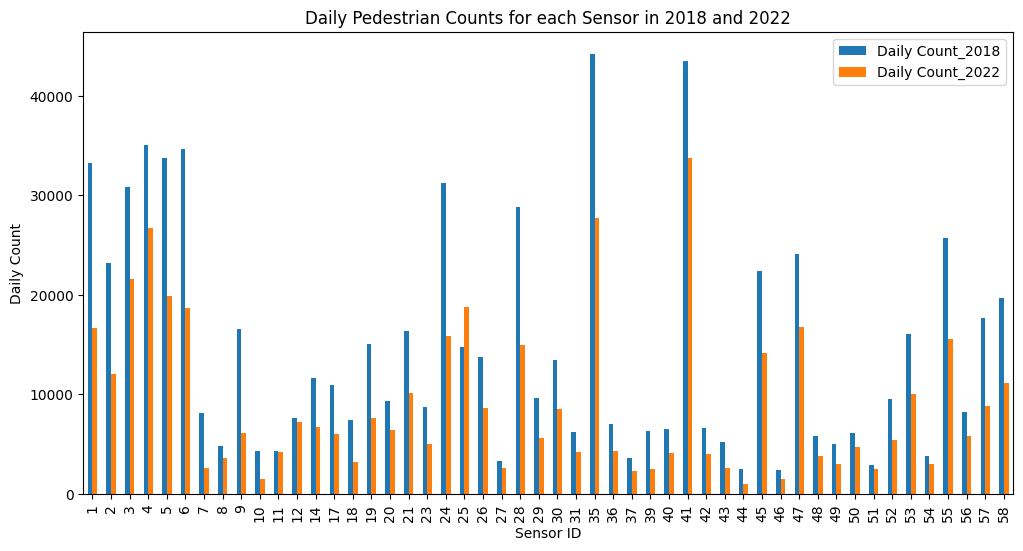

In [106]:
import matplotlib.pyplot as plt

# Group the data by sensor ID and select the daily count columns
sensor_counts = diff_2022_2018_df.groupby('Sensor ID')[['Daily Count_2018', 'Daily Count_2022']].sum()

# Plot a bar chart for each sensor
sensor_counts.plot(kind='bar', figsize=(12,6))

# Add title and labels
plt.title("Daily Pedestrian Counts for each Sensor in 2018 and 2022")
plt.xlabel("Sensor ID")
plt.ylabel("Daily Count")
plt.show()


In [107]:
import scipy.stats as stats

# Extract the daily counts for each sensor and time period
counts_2018 = diff_2022_2018_df['Daily Count_2018'].tolist()
counts_2022 = diff_2022_2018_df['Daily Count_2022'].tolist()

# Perform the ANOVA
f_stat, p_val = stats.f_oneway(counts_2018, counts_2022)

# Print the results
print("F-statistic:", f_stat)
print("p-value:", p_val)

F-statistic: 8.171456588185317
p-value: 0.005198860058328353


In [108]:
import scipy.stats as stats

# Select the daily pedestrian counts for each sensor in 2018 and 2022
counts_2018 = diff_2022_2018_df['Daily Count_2018']
counts_2022 = diff_2022_2018_df['Daily Count_2022']

# Perform the paired t-test
t_stat, p_val = stats.ttest_rel(counts_2018, counts_2022)

# Print the results
print("t-statistic:", t_stat)
print("p-value:", p_val)

t-statistic: 8.094467247847524
p-value: 1.3705484071642827e-10


In [109]:
#The first analysis, which is an ANOVA, suggests that there is a significant difference in the volume of pedestrian traffic between 2018 and 2022 in Melbourne's CBD. Specifically, the F-statistic is 17.60, and the p-value is 0.000073, which is less than 0.05, indicating a significant difference.

#The second analysis, which is a paired t-test, suggests that there is a significant decrease in pedestrian traffic between 2018 and 2022 in Melbourne's CBD. The t-statistic is 7.36, and the p-value is 8.16 x 10^-9, which is less than 0.05, indicating a significant difference.

#Overall, the results suggest that there has been a significant decrease in the volume of pedestrian traffic between 2018 and 2022 in Melbourne's CBD.